In [1]:
%matplotlib widget
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.linalg import det
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import warnings
warnings.filterwarnings("ignore")

### functions for rectangle intersections
def rotate_detector_2d(l=80, b=40, e_det=10, beta=0):
    """rotates the detector around the center of the flange by beta, where the long detector axis is along x for beta = 0"""
    e1 = np.array([b/2,  l/2+e_det, 0])
    e2 = np.array([-b/2, l/2+e_det, 0])
    e3 = np.array([-b/2, -l/2+e_det, 0])
    e4 = np.array([b/2,  -l/2+e_det, 0])
    r_beta = Rotation.from_euler('z', [beta], degrees=False)
    e1,e2,e3,e4 = r_beta.apply([e1,e2,e3,e4])
    return np.array([e1[:2],e2[:2],e3[:2],e4[:2]])

def radii_rectangle(l=80, b=40, e_det=10, e_sample=np.array([0,46]), gam=np.array([0]), beta=0):
    """calculates the distance between sample and the intersection points of the detector projected onto the x-z pllane for given beta and gamma angles"""

    gam = -gam
    s = e_sample
    s1 = np.zeros((len(gam),2,2)) + s

    s1[:,0,0] = s1[:,0,0] -250*np.array(np.cos(gam))
    s1[:,0,1] = s1[:,0,1] +250*np.array(np.sin(gam))
    s1[:,1,0] = s1[:,1,0] +250*np.array(np.cos(gam))
    s1[:,1,1] = s1[:,1,1] -250*np.array(np.sin(gam))
    
    e1,e2,e3,e4 = rotate_detector_2d(l=l, b=b, e_det=e_det, beta=beta)
    es = np.array([[e1,e2], [e1,e4], [e2,e3], [e3,e4]])
    M = np.array( [np.array([np.divide( det([p1-p3,p3-p4]),det([p1-p2,p3-p4])) for p3, p4 in zip(s1[:,0],s1[:,1]) ]) for p1,p2 in es])
    M[~((M<1.)&(M>0.))] = np.nan
    
    p1s = es[:,0]
    p2s = es[:,1]
    intersects = np.array([m[:,None]*(p2s-p1s)+p1s for m in M.T])
    radii_2d = np.linalg.norm(intersects-s, axis=2)*(intersects-s)[:,:,1]/-abs((intersects-s)[:,:,1])
    radii_2d = np.array([np.nanmax(radii_2d, axis=1), np.nanmin(radii_2d, axis=1)])
    
    return radii_2d

### functions for circle intersections
def radii(gamma, x0, y0, r):
    '''calculates the two intersections of a line from the origin with the circle defining the window'''
    r1 = np.cos(gamma)*x0+np.sin(gamma)*y0 + np.sqrt((np.cos(gamma)*x0+np.sin(gamma)*y0)**2  -(x0**2+y0**2-r**2))
    r2 = np.cos(gamma)*x0+np.sin(gamma)*y0 - np.sqrt((np.cos(gamma)*x0+np.sin(gamma)*y0)**2  -(x0**2+y0**2-r**2))
    return (r1,r2)

def excentricity(beta, e_window, e_sample=[0,-46]):
    '''calculates the excentricity of the circle defining the window for different top flange rotations'''
    x0 = np.cos(beta)*e_window - e_sample[0]
    y0 = np.sin(beta)*e_window - e_sample[1]
    return x0, y0

def phi(r, h):
    '''
    Returns the scatter angle measured from the vertical of r with height above the sample,h.
    '''
    return np.arctan(r/h)

def delta_from_beta(beta, gamma, r, e_window, e_sample, h):
    x0,y0 = excentricity(beta, e_window, e_sample)
    radiis = radii(gamma, x0, y0,r)
    deltas = [90-np.rad2deg(phi(radiius, h)) for radiius in radiis]
    return deltas

def circle(beta, e_window, e_sample, r):
    '''calculates the excentricity of the circle defining the window for different top flange rotations'''
    x0,y0 = excentricity(beta, e_window, e_sample)
    phi = np.linspace(0, 2*np.pi, 3601, endpoint=True)
    x = r * np.cos(phi) - x0
    y = r * np.sin(phi) - y0
    return x, y

'''In-vacuum detector - scattering angles 1 position'''
gamma_invac = np.linspace(0.001, np.pi+0.001, 121, endpoint=True)
h_invac = 42
l_invac = 80
b_invac = 40
e_invac = 36
e_sample_invac = np.array([0,46])
beta=np.deg2rad(0)
radii_2d = radii_rectangle(l=l_invac, b=b_invac, e_det=e_invac, e_sample=e_sample_invac, gam=gamma_invac, beta=beta )
deltamin, deltamax = [90-np.rad2deg(phi(radii_2d[0], h_invac)),90-np.rad2deg(phi(radii_2d[1], h_invac))]
source_invac = dict(x=np.rad2deg(gamma_invac), y1=deltamin, y2 = deltamax)
rect_edges_invac = rotate_detector_2d(l=l_invac, b=b_invac, e_det=e_invac, beta=beta) - e_sample_invac
rect_edges_invac = np.vstack([rect_edges_invac,rect_edges_invac[0]])
source_invac_rect = dict(x=rect_edges_invac.T[0], y=rect_edges_invac.T[1])

'''In-vacuum detector - scattering angles cumulative all position'''
betas = np.linspace(0,2*np.pi, 60)
gammas = np.linspace(0.001,np.pi+0.001, 60)
radii_2d = np.array([radii_rectangle(l=l_invac, b=b_invac, e_det=e_invac, e_sample=e_sample_invac, gam=gammas, beta=beta ) for beta in betas])
rs = np.array([np.nanmax(radii_2d, axis=(0,1)), np.nanmin(radii_2d, axis=(0,1))])
deltamin, deltamax = [90-np.rad2deg(phi(rs[0], h_invac)),90-np.rad2deg(phi(rs[1], h_invac))]
source_invac_full_betas = dict(x=np.rad2deg(gammas), y1=deltamin, y2 = deltamax)


'''Beryllium window - scattering angles 1 position'''
gamma = np.linspace(0, np.pi, 361, endpoint=True)
h = 36
r = 70/2
e_window = 30
e_sample = [0,-46]
beta=0
deltamin, deltamax = delta_from_beta(np.deg2rad(beta-90), gamma, r, e_window, e_sample, h)
source_window = dict(x=np.rad2deg(gamma), y1=deltamin, y2 = deltamax)

x,y = circle(np.deg2rad(beta-90), e_window, e_sample, r)
source_window_circle = dict(x=x, y=y)

'''Be window - scattering angles cumulative all position'''
betas = np.linspace(0,2*np.pi, 360)
delta_from_beta(np.deg2rad(0), gamma, r, e_window, e_sample, h)
ds = np.array([delta_from_beta(beta, gamma, r, e_window, e_sample, h) for beta in betas])
dmins =  np.array([np.nanmin(dmin) for dmin in ds[:,0,:].T])
dmaxs = np.array([np.nanmax(dmax) for dmax in ds[:,1,:].T])
source_window_full_betas = dict(x=np.rad2deg(gamma), y1=dmins, y2 = dmaxs)


'''Top flange - scattering angles'''
h_t = 102
r_t = 248.5/2
e_window_t = 0
deltamin_t, deltamax_t = delta_from_beta(0, gamma, r_t, e_window_t, e_sample, h_t)
source_top_flange = dict(x=np.rad2deg(gamma), y1=deltamin_t, y2 = deltamax_t)

x,y = circle(0, e_window_t, e_sample, r_t)
source_top_flange_circle = dict(x=x, y=y)


def update_plot_invac(new):
    beta = new-90
    radii_2d = radii_rectangle(l=l_invac, b=b_invac, e_det=e_invac, e_sample=e_sample_invac, gam=gamma_invac, beta=np.deg2rad(new) )
    deltamin, deltamax = [90-np.rad2deg(phi(radii_2d[0], h_invac)),90-np.rad2deg(phi(radii_2d[1], h_invac))]
    source_invac = dict(x=np.rad2deg(gamma_invac), y1=deltamin, y2 = deltamax)
    invac_y1.set_ydata(source_invac["y1"])
    invac_y2.set_ydata(source_invac["y2"])
    #invac_fill.remove()
    #invac_fill = ax[0].fill_between(source_invac['x'],source_invac['y2'], source_invac['y1'], color='seagreen', alpha=0.2)
    rect_edges_invac = rotate_detector_2d(l=l_invac, b=b_invac, e_det=e_invac, beta=np.deg2rad(new)) - e_sample_invac
    rect_edges_invac = np.vstack([rect_edges_invac,rect_edges_invac[0]])
    source_invac_rect = dict(x=rect_edges_invac.T[0], y=rect_edges_invac.T[1])
    invac_rect.set_xdata(source_invac_rect['x'])
    invac_rect.set_ydata(source_invac_rect['y'])

    
def update_plot_window(new):
    beta = new-90
    deltamin, deltamax = delta_from_beta(np.deg2rad(beta), gamma, r, e_window, e_sample, h)
    source_window = dict(x=np.rad2deg(gamma), y1=deltamin, y2 = deltamax)
    window_y1.set_ydata(source_window["y1"])
    window_y2.set_ydata(source_window["y2"])
    x,y = circle(np.deg2rad(beta), e_window, e_sample, r)
    source_window_circle = dict(x=x, y=y)
    window_circle.set_xdata(source_window_circle['x'])
    window_circle.set_ydata(source_window_circle['y'])


from PIL import Image
imgurl_be = 'https://drive.switch.ch/index.php/apps/files_sharing/ajax/publicpreview.php?x=3360&y=1040&a=true&file=Be_window9.JPG&t=WgAa3cg9sgVJFZK&scalingup=0'
imgurl_be_side = 'https://drive.switch.ch/index.php/apps/files_sharing/ajax/publicpreview.php?x=2550&y=1597&a=true&file=Be_window10.JPG&t=3ugQUzLtWw1ahRd&scalingup=0'
imgurl_invac = 'https://drive.switch.ch/index.php/apps/files_sharing/ajax/publicpreview.php?x=2550&y=1597&a=true&file=Invac4.JPG&t=NYBe6s2jUt4fRMX&scalingup=0'
imgurl_invac_side = 'https://drive.switch.ch/index.php/apps/files_sharing/ajax/publicpreview.php?x=2550&y=1597&a=true&file=invac3.JPG&t=EhuT6m5freJuqas&scalingup=0'
imgurl_otti_side = 'https://drive.switch.ch/index.php/apps/files_sharing/ajax/publicpreview.php?x=2550&y=1597&a=true&file=Fig12.jpg&t=QMe69Re1e64JVEA&scalingup=0'
imgurl_otti = 'https://drive.switch.ch/index.php/apps/files_sharing/ajax/publicpreview.php?x=2563&y=881&a=true&file=Ruessel6.JPG&t=P8IGFeXpkoNIxtP&scalingup=0'
#g.image_url(url=[imgurl], x=-165.5, y=-202.5, w=330, h=350, anchor="bottom_left")

from urllib.request import urlopen
#imgurl = 'https://upload.wikimedia.org/wikipedia/commons/4/41/Sunflower_from_Silesia2.jpg'
img_be = np.asarray(Image.open(urlopen(imgurl_be)))
img_invac = np.asarray(Image.open(urlopen(imgurl_invac)))
img_be_side = np.asarray(Image.open(urlopen(imgurl_be_side)))
img_invac_side = np.asarray(Image.open(urlopen(imgurl_invac_side)))
img_otti = np.asarray(Image.open(urlopen(imgurl_otti)))
img_otti_side = np.asarray(Image.open(urlopen(imgurl_otti_side)))


from ipywidgets import interactive, widgets, Layout, HBox, Output, VBox

out = Output()
with out:
    fig, ax = plt.subplots(3,3, sharex=False, figsize=(12,12))

    iax = np.roll(ax[0,::-1],-1,axis=0)
    ax = np.roll(ax[1:,::-1],-1, axis=1)
    iax[0].set_title(r'$Invacuum$ $detector$')
    iax[1].set_title(r'$Be$ $window$')
    iax[2].set_title(r'$Motorized$ $Invacuum$')
    iax[0].imshow(img_invac_side)
    iax[1].imshow(img_be_side)
    iax[2].imshow(img_otti_side)

    for a in iax:
        a.axis('off')
    
    ax[0][0].imshow(img_invac, extent=[-165.5,330-165.5,-202.5,350-202.5])
    ax[0][1].imshow(img_be, extent=[-165.5,330-165.5,-202.5,350-202.5])
    ax[0][0].xaxis.set_ticklabels(["1","150","100","50","0","-50","-100","-150"])
    ax[0][1].xaxis.set_ticklabels(["1","150","100","50","0","-50","-100","-150"])
    ax[0][2].xaxis.set_ticklabels(["300","200","100","0","-100","-200","-300"])

    ax[0][0].yaxis.set_ticklabels(["1","200","150","100","50","0","-50","-100"])
    ax[0][1].yaxis.set_ticklabels(["1","200","150","100","50","0","-50","-100"])
    ax[0][2].yaxis.set_ticklabels(["1","200","100","0","-100"])

    ax[0][2].set_xlim(-300,300)
    

    otti_scale = 304.8/655
    otti_sample_pos = np.array([img_otti.shape[0]-318, 645])*otti_scale
    otti_size = np.asarray(img_otti.shape[:2])*otti_scale
    ax[0][2].imshow(img_otti, extent=[-otti_sample_pos[1],otti_size[1]-otti_sample_pos[1], -otti_sample_pos[0],otti_size[0]-otti_sample_pos[0] ])
    window_circle, = ax[0][1].plot(source_window_circle['x'],source_window_circle['y'], color='royalblue')
    invac_rect, = ax[0][0].plot(source_invac_rect['x'],source_invac_rect['y'], color='seagreen')


    invac_y1, = ax[1][0].plot(source_invac['x'], source_invac['y1'], color='seagreen', label=r'$Accessible$ $diffraction$ $angles$')
    invac_y2, = ax[1][0].plot(source_invac['x'], source_invac['y2'], color='seagreen')
    ax[1][0].plot(source_invac_full_betas['x'], source_invac_full_betas['y1'], color='seagreen', linestyle=(5,(4,4)))
    ax[1][0].plot(source_invac_full_betas['x'], source_invac_full_betas['y2'], color='seagreen', linestyle=(5,(4,4)))
    #ax[0].fill_between(source_invac['x'],source_invac['y2'], source_invac['y1'], color='seagreen', alpha=0.2)
    ax[1][1].plot(source_top_flange['x'], source_top_flange['y1'], color='grey', label='$CF250$ $flange$ $boundary$', alpha=0.8)
    ax[1][1].plot(source_top_flange['x'], source_top_flange['y2'], color='grey', alpha=0.8)
    window_y1, = ax[1][1].plot(source_window['x'], source_window['y1'], color='royalblue', label=r'$Accessible$ $diffraction$ $angles$')
    window_y2, = ax[1][1].plot(source_window['x'], source_window['y2'], color='royalblue')
    ax[1][1].plot(source_window_full_betas['x'], source_window_full_betas['y1'], color='royalblue', linestyle=(5,(4,4)))
    ax[1][1].plot(source_window_full_betas['x'], source_window_full_betas['y2'], color='royalblue', linestyle=(5,(4,4)))
    #ax[1].fill_between(source_window['x'],source_window['y2'], source_window['y1'], color='royalblue', alpha=0.2)


    #import IPython
    #url = 'https://newevolutiondesigns.com/images/freebies/colorful-background-14.jpg'
    #IPython.display.Image(imgurl, width = 250)

    ax[0][0].set_ylabel(r'$Distance$ $x$ $(mm)$')

    ax[0][1].set_ylabel(r'$Distance$ $x$ $(mm)$')
    ax[0][2].set_ylabel(r'$Distance$ $x$ $(mm)$')
    ax[0][0].set_xlabel(r'$Distance$ $z$ $(mm)$')
    ax[0][1].set_xlabel(r'$Distance$ $z$ $(mm)$')
    ax[0][2].set_xlabel(r'$Distance$ $z$ $(mm)$')

    ax[1][0].set_ylabel(r'$Elevation$ $\delta$ $(°)$')
    ax[1][1].set_ylabel(r'$Elevation$ $\delta$ $(°)$')
    ax[1][2].set_ylabel(r'$Elevation$ $\delta$ $(°)$')

    ax[1][0].set_xlabel(r'$Azimuth$ $\gamma$ $(°)$')
    ax[1][1].set_xlabel(r'$Azimuth$ $\gamma$ $(°)$')
    ax[1][2].set_xlabel(r'$Azimuth$ $\gamma$ $(°)$')

    ax[1][0].set_xlim(0,180)
    ax[1][0].set_ylim(0,180)
    ax[1][1].set_xlim(0,180)
    ax[1][1].set_ylim(0,180)
    ax[1][0].legend(frameon=False, loc='upper center')
    ax[1][1].legend(frameon=False, loc='upper center', ncol=1)
    ax[1][0].tick_params(direction='in')
    ax[1][0].tick_params(direction='in')
    ax[1][1].tick_params(direction='in')
    ax[1][1].tick_params(direction='in')
    ax[1][0].set_xticks([0,30,60,90,120,150,180])
    ax[1][1].set_xticks([0,30,60,90,120,150,180])
    ax[1][2].set_xticks([0,30,60,90,120,150,180])

    ax[1][0].set_yticks([0,45,90,135,180])
    ax[1][1].set_yticks([0,45,90,135,180])
    ax[1][2].set_yticks([0,45,90,135,180])
    fig.tight_layout()
    plt.show()


## ipywidgets
slider = widgets.IntSlider(
value=0,
    min=0,
    max=360,
    step=15,
    description='Rotation (°)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
slider2 = widgets.IntSlider(
value=0,
    min=0,
    max=360,
    step=15,
    description='Rotation (°)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

sl1=interactive(update_plot_invac, new=slider);
sl2=interactive(update_plot_window, new=slider2);
#box_layout = Layout(display='flex', flex_flow='column', justify_content='center', align_items='center', width='400px')
box_layout = Layout(justify_content='center', align_items='center', width='400px')

    
#display(HBox([out, sl1, sl2], layout=box_layout))

l1 = widgets.Label(
    value='Invacuum detector rotation')
l2 = widgets.Label(
    value='Be window flange rotation')

s1 = VBox([l1,sl1], layout=box_layout)
s2 = VBox([l2,sl2], layout=box_layout)
#s1.layout.width='500px'
#s2.layout.width='500px'

display(VBox([out, HBox([s2,s1 ])]))



In [20]:
def calc_otti(
    ottinu,
    ottidel,
    ottidet=None,
    ottidetdist=179.287,
    Nxpix=1024,
    Nzpix=512,
    pixsize=75e-3,
    rotcencoo=np.asarray([46, 77.436, 0]),
    plotit=False,
):

    x = np.arange(Nxpix) * pixsize
    z = np.arange(Nzpix) * pixsize
    y = np.asarray([ottidetdist])
    x = x - np.mean(x.ravel())
    z = z - np.mean(z.ravel())
    X, Y, Z = np.meshgrid(x, y, z)

    pixcoo = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    detdir = np.asarray([0, -1, 0])

    rotcencoo = np.asarray([46, 77.436, 0])
    samplecoo = np.asarray([0, 0, 0])

    ottidel = np.radians(ottidel)
    ottinu = np.radians(ottinu)
    if ottidet is None:
        ottidet = -ottinu
    else:
        ottidet = np.radians(ottidet)

    pixcoo_ottidet = np.asarray(
        Rotation.from_rotvec(np.asarray([0, ottidet, 0])).as_matrix()
        * np.asmatrix(pixcoo)
    )
    pixcoo_ottidel = np.asarray(
        Rotation.from_rotvec(np.asarray([ottidel, 0, 0])).as_matrix()
        * np.asmatrix(pixcoo_ottidet)
    )
    pixcoo_ottinu = np.asarray(
        Rotation.from_rotvec(np.asarray([0, ottinu, 0])).as_matrix()
        * np.asmatrix(pixcoo_ottidel)
    )
    pixcoo_otti = pixcoo_ottinu + rotcencoo[:, np.newaxis]

    detdir_otti = np.asarray(
        Rotation.from_rotvec(np.asarray([0, ottinu, 0])).as_matrix()
        * (
            Rotation.from_rotvec(np.asarray([ottidel, 0, 0])).as_matrix()
            * np.asmatrix(detdir[:, np.newaxis])
        )
    )
    rxz = pixcoo_otti[0] ** 2 + pixcoo_otti[2] ** 2

    pixdist = np.sqrt(rxz + pixcoo_otti[1] ** 2).reshape(X.shape[1:])
    nu = np.arctan2(pixcoo_otti[0], pixcoo_otti[2]).reshape(X.shape[1:])
    delta = np.arctan2(pixcoo_otti[1], np.sqrt(rxz)).reshape(X.shape[1:])

    if plotit:
        fig = plt.figure(figsize=[8, 4])

        ax = fig.add_subplot(1, 3, 1, projection="3d")

        plpixcoo = np.roll(pixcoo + rotcencoo[:, np.newaxis], 1, axis=0)
        plpixcoo_otti = np.roll(pixcoo_otti, 1, axis=0)
        plrotcencoo = np.roll(rotcencoo, 1, axis=0)
        plsamplecoo = np.roll(samplecoo, 1, axis=0)

        ax.set_box_aspect(
            np.ptp(
                np.concatenate(
                    [
                        plpixcoo,
                        plpixcoo_otti,
                        plrotcencoo[:, np.newaxis],
                        plsamplecoo[:, np.newaxis],
                    ],
                    axis=1,
                ),
                axis=1,
            )
        )
        # ax.set_box_aspect(np.ptp(pixcoo,axis=1))
        ax.plot(*plrotcencoo, "om")

        ax.plot(*plsamplecoo, "sr")
        ax.plot(*[get_array_frame(ta.reshape(X.shape[1:])) for ta in plpixcoo], ":b")
        # ax.plot(*plpixcoo,'.b')
        # ax.plot(*plpixcoo_otti,'xg')
        ax.plot(
            *[get_array_frame(ta.reshape(X.shape[1:])) for ta in plpixcoo_otti], "g"
        )

        ax.set_xlabel("z / mm")
        ax.set_ylabel("x / mm")
        ax.set_zlabel("y / mm")
        # ax.set_box_aspect((np.ptp(np.concatenate([pixcoo,pixcoo_ottidel,pixcoo_ottidet],axis=0),axis=1)

        axn = fig.add_subplot(1, 3, 2)
        axn.set_xlabel("nu / °")
        axn.set_ylabel("delta / °")

        i1 = axn.plot(
            np.degrees(get_array_frame(nu)), np.degrees(get_array_frame(delta)), "-g"
        )
        axp = fig.add_subplot(1, 3, 3, projection="polar")
        axp.set_ylabel("nu / °")
        axp.set_xlabel("delta / °")
        axp.set_rlim(bottom=90, top=45)
        axp.set_theta_zero_location("N", offset=0.0)

        ip = plt.plot(get_array_frame(nu), np.degrees(get_array_frame(delta)), "-g")
        plt.tight_layout()

        print(f"Average detector distance: {np.mean(pixdist)} mm")
        print(f"Average nu angle: {np.degrees(np.mean(nu))}°")
        print(f"Average delta angle: {np.degrees(np.mean(delta))}°")
        print(detdir_otti)
    return get_array_frame(nu), get_array_frame(delta)
def get_array_frame(a):
    return np.concatenate([a[:, 0], a[-1, 1:], a[-2::-1, -1], a[0, -2::-1]])

In [29]:
nu, delta = calc_otti(50,10)

In [30]:
plt.plot(nu)

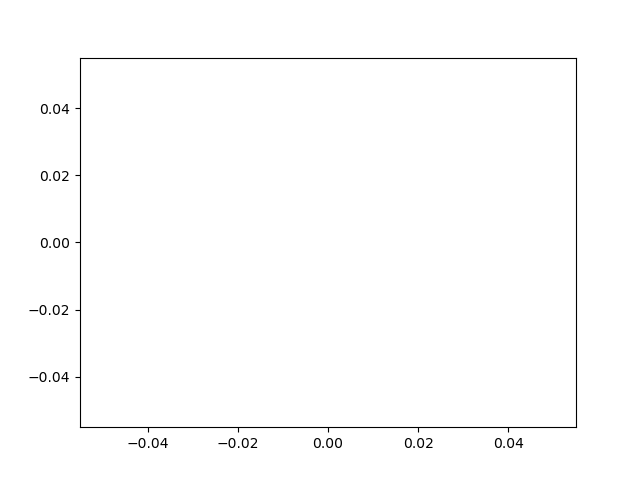

In [36]:
plt.figure()
plt.plot(d)

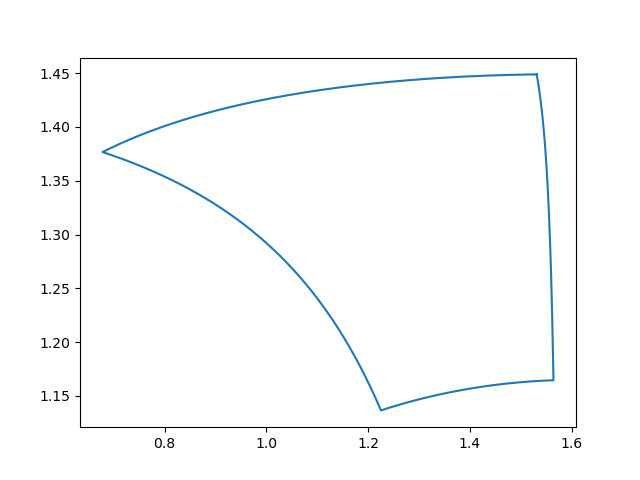

In [32]:
plt.figure()
plt.plot(nu, delta)

In [39]:
ns[0]

array([2.76232404, 2.75895121, 2.75558751, ..., 2.75961352, 2.76097337,
       2.76232404])

In [42]:
n = ns[0]
d = ds[0]

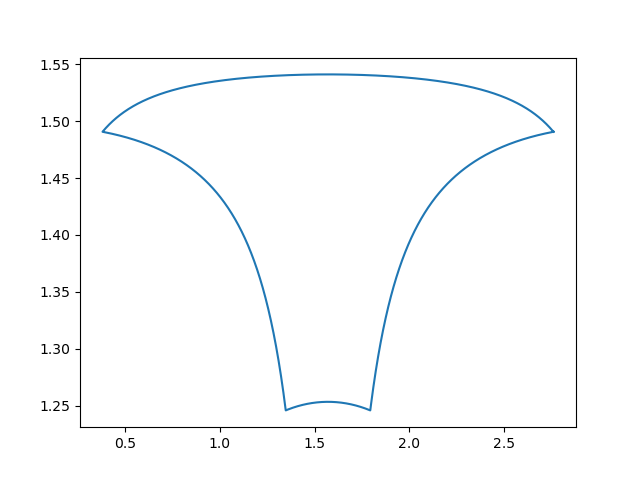

In [50]:
plt.figure()
plt.plot(n,d)

In [51]:
x = np.arange(0,3,0.0001)

In [49]:
n

array([2.76232404, 2.75895121, 2.75558751, ..., 2.75961352, 2.76097337,
       2.76232404])

In [54]:
y = np.interp(x,n,d)

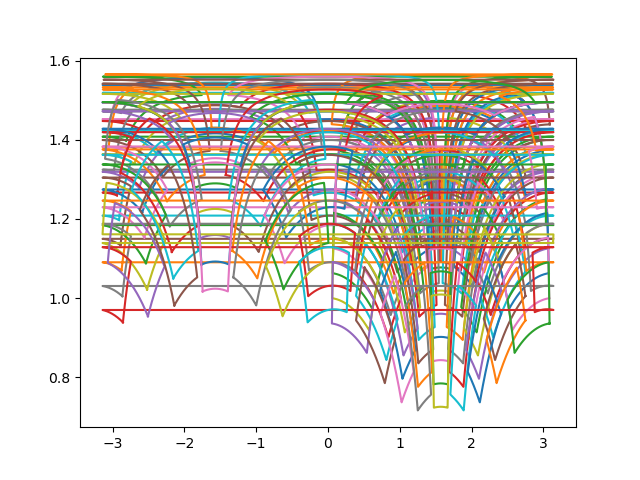

In [56]:
plt.figure()
for n, d in zip(ns, ds):
    plt.plot(n,d)

In [63]:
y1 = np.array([np.min(d) for d in ds])
x1 = np.array([n[np.argmin(d)] for n, d in zip(ns,ds)])
y2 = np.array([np.max(d) for d in ds])
x2 = np.array([n[np.argmax(d)] for n, d in zip(ns,ds)])

In [91]:
x = np.arange(-np.pi, np.pi, 0.4)
idx = np.digitize(x1,x)
y = [np.min(y1[idx==n]) for n in idx]
x = x[idx]

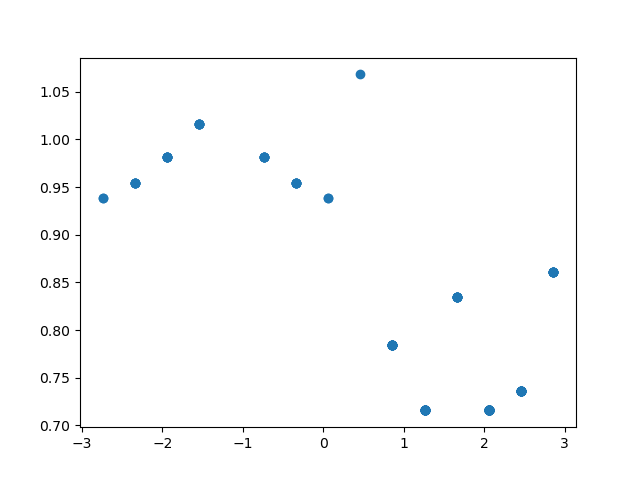

In [92]:
plt.figure()
plt.plot(x,y,'o')

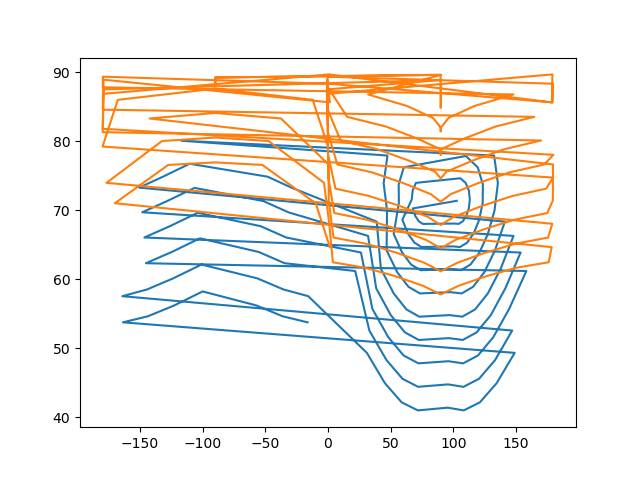

In [66]:
plt.figure()

plt.plot(np.rad2deg(x1),np.rad2deg(y1))
plt.plot(np.rad2deg(x2),np.rad2deg(y2))

In [232]:
nus = np.arange(0,360,15)
deltas = np.arange(0,46,5)

ns = []
ds = []

x1 = []
x2 = []
y1 = []
y2 = []

for delta in deltas:
    for nu in nus:
        n,d = calc_otti(nu, delta)
        y1.append(np.min(d))
        x1.append(n[np.argmin(d)])
        y2.append(np.max(d))
        x2.append(n[np.argmax(d)])
x1 = np.array(x1)
x2 = np.array(x2)
y1 = np.array(y1)
y2 = np.array(y2)

KeyboardInterrupt: 

In [202]:
x1 = np.array(x1)
x2 = np.array(x2)
y1 = np.array(y1)
y2 = np.array(y2)

In [ ]:
idx = np.argsort(x1)
x1 = x1[idx]
y1 = y1[idx]
idx = np.argsort(x2)
x2 = x2[idx]
y2 = y2[idx]

In [234]:
def sortxy(x,y):
    idx = np.argsort(x)
    xs = np.asarray(x)[idx]
    ys = np.asarray(y)[idx]
    return xs, ys

def split_arrays(n,d):
    diff = np.diff(n)
    x = np.arange(np.min(n), np.max(n), abs(diff[0]))
    n1 = np.asarray(n)[:-1][diff>0]
    n2 = np.asarray(n)[:-1][diff<0]
    d1 = np.asarray(d)[:-1][diff>0]
    d2 = np.asarray(d)[:-1][diff<0]
    n1, d1 = sortxy(n1,d1)
    n2, d2 = sortxy(n2,d2)
    if np.sum(d1)<np.sum(d2):
        d1i = np.interp(x,n1,d1)
        d2i = np.interp(x,n2,d2)
    else:
        d2i = np.interp(x,n1,d1)
        d1i = np.interp(x,n2,d2)
    return x,d1i,d2i


In [345]:
nus = np.arange(0,360,7.5)
deltas = np.arange(0,46,2.5)

ns = []
ds = []

for delta in deltas:
    for nu in nus:
        n,d = calc_otti(nu, delta)
        ns.append(n)
        ds.append(d)

In [346]:
res = np.array([split_arrays(n,d) for n,d in zip(ns,ds)])


In [347]:
ns = res.T[0]
d1s = res.T[1]
d2s = res.T[2]
x = np.arange(np.min(np.hstack(ns)), np.max(np.hstack(ns)), 0.02)

idxs = np.array([np.digitize(n,x) for n in ns])
y1 = np.array([np.min(np.hstack([d[idx==n] for d, idx in zip(d1s,idxs)])) for n in np.unique(np.hstack(idxs))])
idxs = np.array([np.digitize(n,x) for n in ns])
y2 = np.array([np.max(np.hstack([d[idx==n] for d, idx in zip(d1s,idxs)])) for n in np.unique(np.hstack(idxs))])

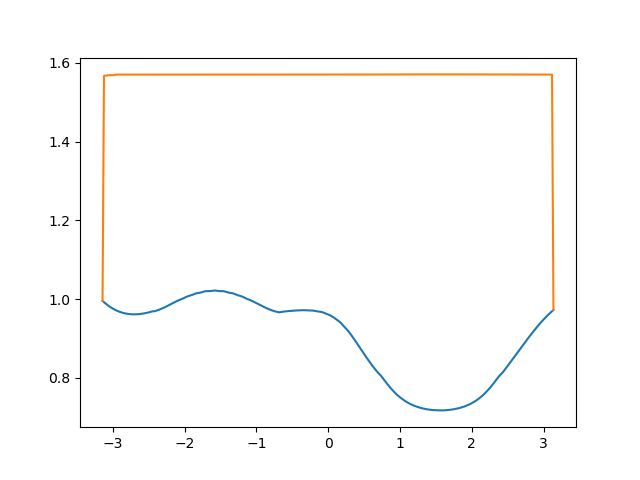

In [362]:
from scipy.signal import savgol_filter
plt.figure()
y2_1 = np.hstack([savgol_filter(y1,71,3)[0],y2[1:-1],savgol_filter(y1,71,3)[-1]])
plt.plot(x,savgol_filter(y1,71,3))
plt.plot(x,y2_1)
np.save('otti.npy',[x,y1,y2,savgol_filter(y1,71,3),y2_1])

In [365]:
x,y1,y2,y1s,y2_1 = np.load('otti.npy')

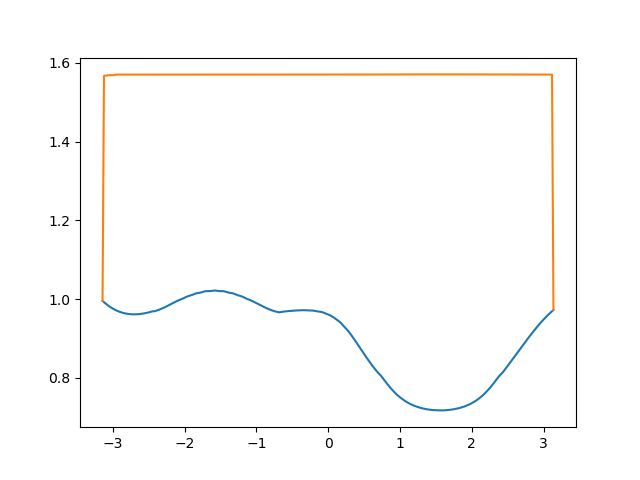

In [367]:
plt.figure()
plt.plot(x,y1s)
plt.plot(x,y2_1)

In [ ]:
#